In [1]:
# importing necessary libraries

import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

import matplotlib.pylab as plt
import seaborn as sns

import dmba
from dmba import classificationSummary, gainsChart, liftChart, regressionSummary, stepwise_selection, plotDecisionTree
from dmba.metric import AIC_score, adjusted_r2_score, BIC_score


In [2]:
bank = pd.read_csv("C:/Users/steph/OneDrive/Documents/USD/ADS505/Data/Bank Customer Churn Prediction.csv")

bank.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
bank.dtypes

customer_id           int64
credit_score          int64
country              object
gender               object
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
churn                 int64
dtype: object

In [5]:
bank.isnull().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

No nulls in the dataset. Data types seem to be correct off the bat.

Other ideas:

Product_number -- seems to be categorical, may need to dummy

Country -- categorical, may need to dummy

Gender - make binary vs 2 categories (1s, 0s)


In [7]:
bank.nunique()

customer_id         10000
credit_score          460
country                 3
gender                  2
age                    70
tenure                 11
balance              6382
products_number         4
credit_card             2
active_member           2
estimated_salary     9999
churn                   2
dtype: int64

There are only 3 different countries and 4 different products. CC and active member are indeed binary. 

In [6]:
bank.describe()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


For binary variables, incl target:

Churn: ~20.4% positive records
CC: ~70.5% positive
active member: ~51.5% positive

For numerical:

cc: seems about symmetrical (median ~= mean); ranges from 350 - 850

age: 18 - 92; slightly skewed right, with mean of 38.9 and median of 37.

tenure: seems symmetrical; anywhere from 0 years to 10 years. 

balance: ranges from $0 to $250k. The median > mean (~97k vs 76k), so it is skewed left

estimated salary: mean / median both around 100k. ranges from 57.5k to ~200k. 

Text(0, 0.5, 'credit_score')

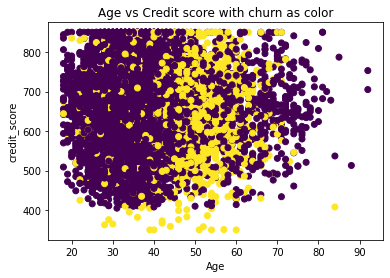

In [30]:
ax = plt.gca()
leg = ax.get_legend()
labels = bank.churn
plt.scatter(bank['age'],bank['credit_score'], c = bank.churn)
plt.title("Age vs Credit score with churn as color")

plt.xlabel('Age')
plt.ylabel('credit_score')

In [38]:
# let's quickly create new datasets where churn = 0 and churn = 1 to easily to some more exploration

no_churn = bank.loc[bank['churn'] == 0]
churn = bank.loc[bank['churn'] == 1]

Text(0, 0.5, 'Count')

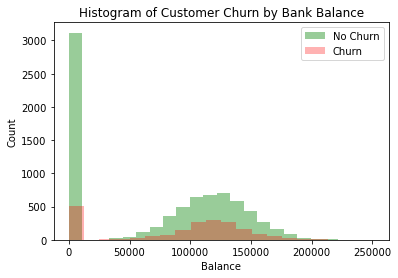

In [44]:
plt.hist(no_churn['balance'], alpha = 0.4, label = 'No Churn', color = 'green', bins = 20)

plt.hist(churn['balance'], alpha = 0.3, label = 'Churn', color = 'red', bins = 20)

plt.title("Histogram of Customer Churn by Bank Balance")

plt.legend(loc = "upper right")

plt.xlabel('Balance')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

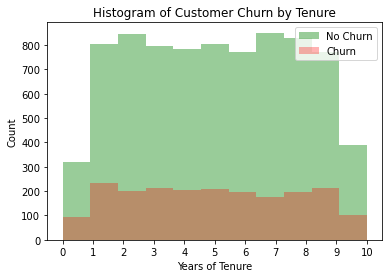

In [52]:
plt.hist(no_churn['tenure'], alpha = 0.4, label = 'No Churn', color = 'green', bins = 11)

plt.hist(churn['tenure'], alpha = 0.3, label = 'Churn', color = 'red', bins = 11)

plt.title("Histogram of Customer Churn by Tenure")

plt.legend(loc = "upper right")

plt.xticks(range(0, 11, 1))

plt.xlabel('Years of Tenure')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

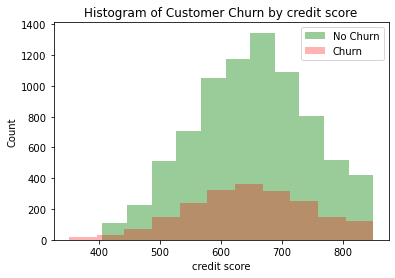

In [54]:
plt.hist(no_churn['credit_score'], alpha = 0.4, label = 'No Churn', color = 'green', bins = 11)

plt.hist(churn['credit_score'], alpha = 0.3, label = 'Churn', color = 'red', bins = 11)

plt.title("Histogram of Customer Churn by credit score")

plt.legend(loc = "upper right")

plt.xlabel('credit score')
plt.ylabel('Count')